## Pixel Level Similarity

SSIM Score: 0.2838 (1 = perfect match)
MSE Score: 6383.6146 (0 = perfect match)
PSNR Score: 10.08 dB (higher = better)
Result: Images are DIFFERENT (SSIM < 0.75)


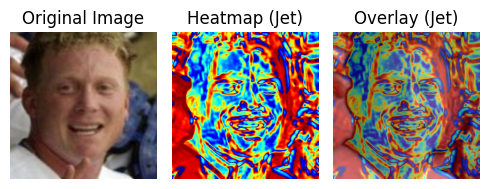

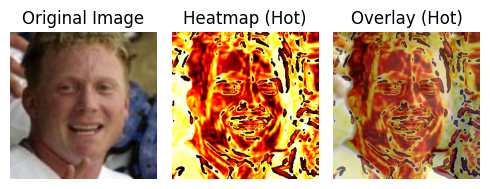

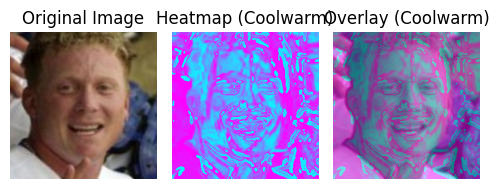

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10

def load_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

def load_color_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def compute_mse(img1, img2):
    return np.mean((img1.astype("float") - img2.astype("float")) ** 2)

def compute_psnr(img1, img2):
    mse_val = compute_mse(img1, img2)
    if mse_val == 0:
        return float("inf")
    return 20 * log10(255.0 / np.sqrt(mse_val))

def apply_overlay(original_img, diff_map, colormap=cv2.COLORMAP_JET, alpha=0.5):
    heatmap = cv2.applyColorMap(diff_map, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    overlayed = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
    return heatmap, overlayed

def compare_images_with_diff_map(img1_path, img2_path, threshold=0.8):
    img1_gray = load_image(img1_path)
    img2_gray = load_image(img2_path)
    img1_rgb = load_color_image(img1_path)
    img2_rgb = load_color_image(img2_path)

    # SSIM comparison
    ssim_score, diff = ssim(img1_gray, img2_gray, full=True)
    mse_score = compute_mse(img1_gray, img2_gray)
    psnr_score = compute_psnr(img1_gray, img2_gray)

    # Normalize and convert diff to uint8
    diff_img = (1 - diff) * 255
    diff_img_uint8 = diff_img.astype("uint8")

    print(f"SSIM Score: {ssim_score:.4f} (1 = perfect match)")
    print(f"MSE Score: {mse_score:.4f} (0 = perfect match)")
    print(f"PSNR Score: {psnr_score:.2f} dB (higher = better)")

    # Threshold check and labeling
    if ssim_score >= threshold:
        print(f"Result: Images are SIMILAR (SSIM >= {threshold})")
    else:
        print(f"Result: Images are DIFFERENT (SSIM < {threshold})")

    # Try different colormaps
    colormaps = {
        'Jet': cv2.COLORMAP_JET,
        'Hot': cv2.COLORMAP_HOT,
        'Coolwarm': cv2.COLORMAP_COOL
    }

    for cmap_name, cmap_code in colormaps.items():
        heatmap, overlay = apply_overlay(img1_rgb, diff_img_uint8, cmap_code)

        fig, axs = plt.subplots(1, 3, figsize=(5, 5))
        axs[0].imshow(img1_rgb)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(heatmap)
        axs[1].set_title(f"Heatmap ({cmap_name})")
        axs[1].axis("off")

        axs[2].imshow(overlay)
        axs[2].set_title(f"Overlay ({cmap_name})")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

# Example usage with threshold 0.75 or 0.8
compare_images_with_diff_map(
    "/kaggle/input/natural-images/natural_images/person/person_0003.jpg",
    "/kaggle/input/natural-images/natural_images/person/person_0001.jpg",
    threshold=0.75
)


## TriVisionNet (Proposed classification model)

In [4]:
import os
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as T
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# -------- Dataset for Image Pairs --------
class PairedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.pairs = []
        self.class_to_idx = {}
        self.images_per_class = {}

        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.images_per_class = {cls: [] for cls in classes}

        for cls in classes:
            cls_folder = os.path.join(root_dir, cls)
            images = [os.path.join(cls_folder, fname) for fname in os.listdir(cls_folder)
                      if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)
            self.images_per_class[cls] = images[:10]  # Cap to 100 images per class

        # Create pairs
        for cls in classes:
            imgs = self.images_per_class[cls]
            for i in range(len(imgs)):
                for j in range(i + 1, len(imgs)):
                    self.pairs.append((imgs[i], imgs[j], 1))  # similar

            other_classes = [c for c in classes if c != cls]
            for img1 in imgs:
                neg_cls = random.choice(other_classes)
                img2 = random.choice(self.images_per_class[neg_cls])
                self.pairs.append((img1, img2, 0))  # dissimilar

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# -------- Feature Extractor --------
class MultiModelFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = models.resnet50(pretrained=True)
        self.model2 = models.efficientnet_b0(pretrained=True)
        self.model3 = models.densenet121(pretrained=True)

        for m in [self.model1, self.model2, self.model3]:
            for module in m.modules():
                if isinstance(module, nn.BatchNorm2d):
                    module.eval()

        self.model1.fc = nn.Identity()
        self.model2.classifier = nn.Identity()
        self.model3.classifier = nn.Identity()

    def forward(self, x):
        f1 = self.model1(x)
        f2 = self.model2(x)
        f3 = self.model3(x)
        return torch.cat([f1, f2, f3], dim=1)

# -------- Similarity Model --------
class ImageSimilarityNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = MultiModelFeatureExtractor()
        self.classifier = nn.Sequential(
            nn.Linear(4352 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        feat1 = self.feature_extractor(img1)
        feat2 = self.feature_extractor(img2)
        combined = torch.cat([feat1, feat2], dim=1)
        return self.classifier(combined).squeeze(1)

# -------- Training and Validation --------
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for img1, img2, labels in tqdm(dataloader, desc="Training"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, labels in tqdm(dataloader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total

# -------- Save and Inference Function --------
def save_model(model, path="similarity_model.pth"):
    torch.save(model.state_dict(), path)

def load_model(path, device):
    model = ImageSimilarityNet().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

def test_on_two_images(model, image_path1, image_path2, transform, device, threshold=0.5):
    img1 = Image.open(image_path1).convert('RGB')
    img2 = Image.open(image_path2).convert('RGB')
    img1 = transform(img1).unsqueeze(0).to(device)
    img2 = transform(img2).unsqueeze(0).to(device)

    with torch.no_grad():
        score = model(img1, img2).item()
    print(f"Similarity Score: {score:.4f}")
    print("Prediction: ", "Similar" if score >= threshold else "Not Similar")

# -------- Main --------
def main():
    data_dir = "/kaggle/input/natural-images/natural_images"  # <-- your dataset path
    batch_size = 8
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    dataset = PairedImageDataset(data_dir, transform=transform)
    indices = list(range(len(dataset)))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42,
                                          stratify=[label for _, _, label in dataset.pairs])
    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ImageSimilarityNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    save_model(model, "similarity_model.pth")
    print("Model saved as similarity_model.pth")

    test_img1 = "/kaggle/input/natural-images/natural_images/fruit/fruit_0011.jpg"
    test_img2 = "/kaggle/input/natural-images/natural_images/flower/flower_0003.jpg"
    model = load_model("similarity_model.pth", device)
    test_on_two_images(model, test_img1, test_img2, transform, device)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most u

Epoch 1/5 - Train Loss: 0.5078, Acc: 0.8182 | Val Loss: 0.5073, Acc: 0.8182


Validation: 100%|██████████| 11/11 [00:01<00:00,  6.48it/s]


Epoch 2/5 - Train Loss: 0.4241, Acc: 0.8153 | Val Loss: 0.9406, Acc: 0.8068


Validation: 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


Epoch 3/5 - Train Loss: 0.4499, Acc: 0.8068 | Val Loss: 0.7124, Acc: 0.7273


Validation: 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


Epoch 4/5 - Train Loss: 0.3665, Acc: 0.8324 | Val Loss: 1.1681, Acc: 0.7273


Validation: 100%|██████████| 11/11 [00:01<00:00,  6.47it/s]


Epoch 5/5 - Train Loss: 0.3985, Acc: 0.8409 | Val Loss: 0.6903, Acc: 0.7614
Model saved as similarity_model.pth
Similarity Score: 0.7896
Prediction:  Similar
